In [3]:
import pandas as pd
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
# Import data and clean tweets
df = pd.read_csv("covid19_tweets.csv")

# exTweet = "strive to promote Truth with Integrity. https://t.co/pOqdhk6Mhg"
def clean_tweet(text):
    ''' Remove links and symbols, make text lowercase'''
    text = text.lower()
    text = re.sub('http\S+', '', text)
    text = re.sub('[^0-9a-zA-Z ]+', '', text)
    return text

df['text_clean'] = df['text'].apply(str).apply(lambda x: clean_tweet(x))

In [86]:
# Get Sentiment from Vader
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
df["Score"] = df["text_clean"].apply(lambda x: sid.polarity_scores(x)) 

# Obtain compound score and filter neutral scores
df['compoundScore'] = df["Score"].apply(lambda x: x['compound'])
df = df[(df['compoundScore']>0.01) | (df['compoundScore']<-0.01)]
df.compoundScore

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/caskla/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


1        -0.6249
3         0.9450
5         0.8979
7         0.2732
15        0.4404
           ...  
258795    0.3182
258797   -0.4767
258798    0.8074
258799    0.7096
258800    0.4215
Name: compoundScore, Length: 189835, dtype: float64

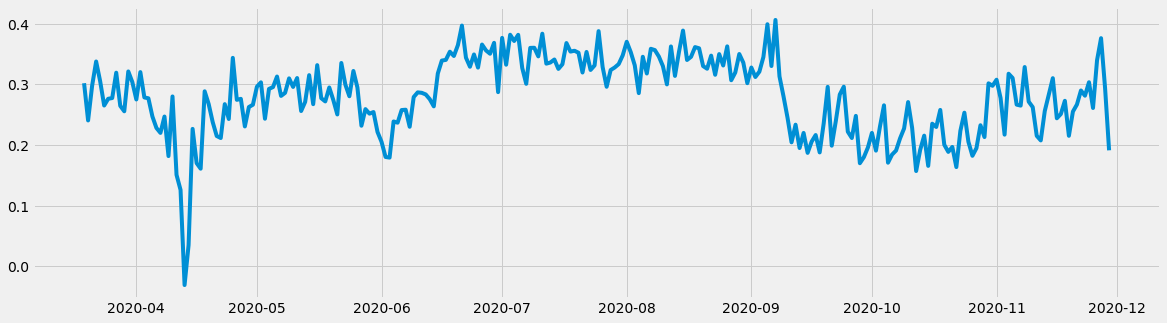

In [77]:
# Plot average score over time 
df['date'] = pd.to_datetime(df['created_at']).dt.date
dates = np.array(df['date'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.plot(df.groupby('date').mean()['compoundScore'])

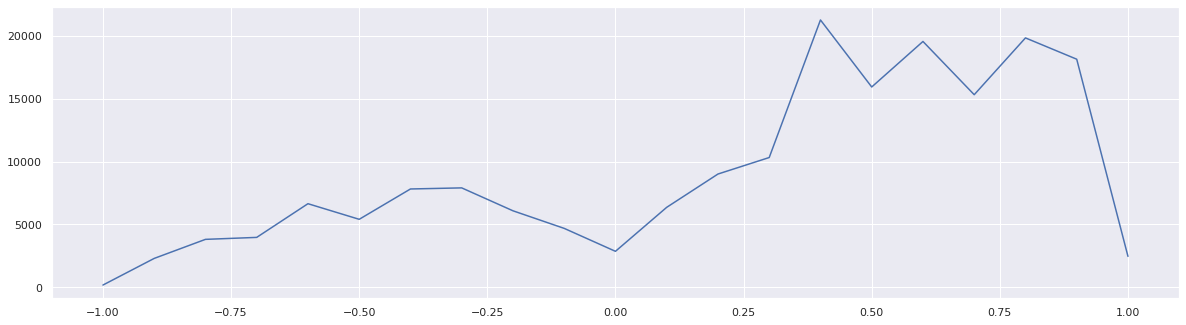

In [8]:
# Plot score distribution
df['roundedCompoundScore'] = df['compoundScore'].round(1)
plt.plot(df.groupby('roundedCompoundScore')['compoundScore'].count())

In [87]:
#Number of random locations listed
print("No. Of Original Unique Locations:",df["user_location"].nunique())
#dropping all null user locations
df.dropna(subset=['user_location'], inplace=True)

No. Of Original Unique Locations: 31071


In [96]:
# dfBak = df
df = dfBak
# x = dfBak.query("user_location == 'Ireland | Scotland | Inuit | Skandinavien'")
# x
# dfBak.loc[df['user_location'].str.contains('Ireland', case=False, na=False)]

In [101]:
# Generalizing Locations: making locations such as New York fall under the United States catagory
df.loc[df['user_location'].str.contains('Ireland', case=False, na=False),['user_location']] = "Ireland"
df.loc[df['user_location'].str.contains('India|Delhi|Mumbai', case=False, na=False),['user_location']] = "India"
df.loc[df['user_location'].str.contains('Toronto', case=False, na=False),['user_location']] = "Canada"
df.loc[df['user_location'].str.contains('England|UK|London|Kingdom', case=False, na=False),['user_location']] = "United Kingdom"
df.loc[df['user_location'].str.contains('Nigeria', case=False, na=False),['user_location']] = "Nigeria"
df.loc[df['user_location'].str.contains('China|Kong', case=False, na=False),['user_location']] = "China"
df.loc[df['user_location'].str.contains('Australia', case=False, na=False),['user_location']] = "Australia"
df.loc[df['user_location'].str.contains('Switzerland', case=False, na=False),['user_location']] = "Switzerland"
df.loc[df['user_location'].str.contains('Worldwide|WORLD|Earth|Global|Text|Europe|Your tongue', case=False, na=False),['user_location']] = "USELESS"
df.loc[df['user_location'].str.contains('USA|United States|DC|NY|CA|MA|LA|MD|TN|GA|TX|PA|WA|FL|York|Texas|Los|Florida', na=False),['user_location']] = "United States"
df = df[df["user_location"]!="USELESS"]
#Number of locations after filtering out the excess
print("No. Of Unique Locations:",df["user_location"].nunique())

/home/caskla/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


No. Of Unique Locations: 20819


/home/caskla/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


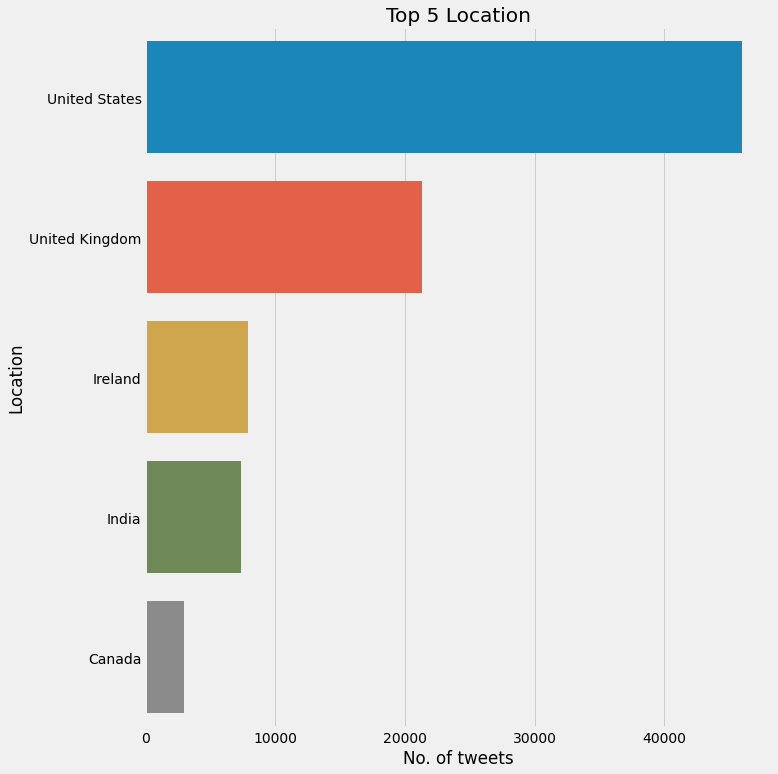

In [102]:
#graph of the top locations with the number of tweets in each respective country
plt.figure(figsize=(10,12))
sns.barplot(df["user_location"].value_counts().values[0:5],
            df["user_location"].value_counts().index[0:5]);
plt.title("Top 5 Location")
plt.xlabel("No. of tweets")
plt.ylabel("Location")
plt.show()

In [37]:
# Validate the model
validation = pd.read_csv("validationset.csv")
old = pd.read_csv("covid19_tweets_old.csv", nrows=100)

old['text_clean'] = old['text'].apply(str).apply(lambda x: clean_tweet(x))
# Get Sentiment from Vader
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()
old["Score"] = old["text_clean"].apply(lambda x: sid.polarity_scores(x)) 

# Obtain compound score and filter neutral scores
old['compoundScore'] = old["Score"].apply(lambda x: x['compound'])
old = old[(old['compoundScore']>0.01) | (old['compoundScore']<-0.01)]
old.compoundScore

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/caskla/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0     0.4939
1     0.2263
2    -0.2732
3     0.7351
4     0.3182
       ...  
93   -0.2960
95   -0.7717
97   -0.1779
98   -0.3818
99    0.4449
Name: compoundScore, Length: 72, dtype: float64

In [38]:
old['validation'] = old.compoundScore - validation.score

In [41]:
old["validation"].mean()

0.1339652777777778

In [ ]:
# Filter Dataframe by country
prominentCountries = df["user_location"].value_counts().index[0:5]
x = df.query("user_location == '" + prominentCountries[0] + "'")

<ipython-input-112-3ae4b4c5663a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['date'] = pd.to_datetime(x['created_at']).dt.date


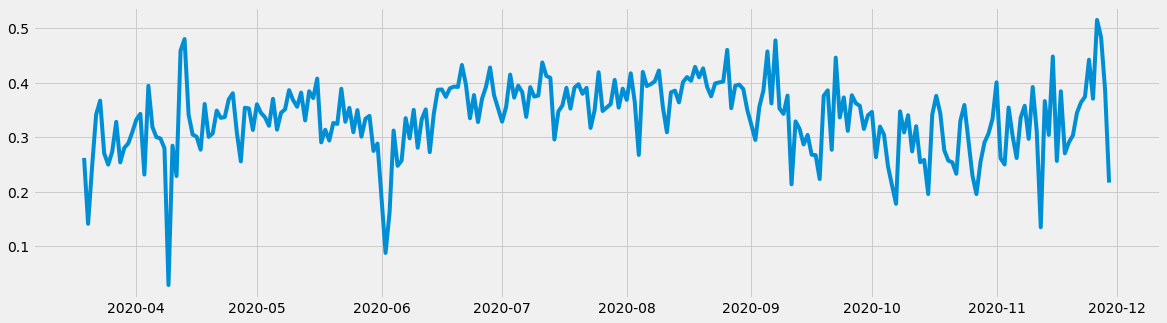

In [112]:
# Plot average score over time for United States countries
x = df.query("user_location == '" + prominentCountries[0] + "'")

x['date'] = pd.to_datetime(x['created_at']).dt.date
dates = np.array(x['date'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.plot(x.groupby('date').mean()['compoundScore'])

<ipython-input-111-a60e2f95f41f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['roundedCompoundScore'] = x['compoundScore'].round(1)


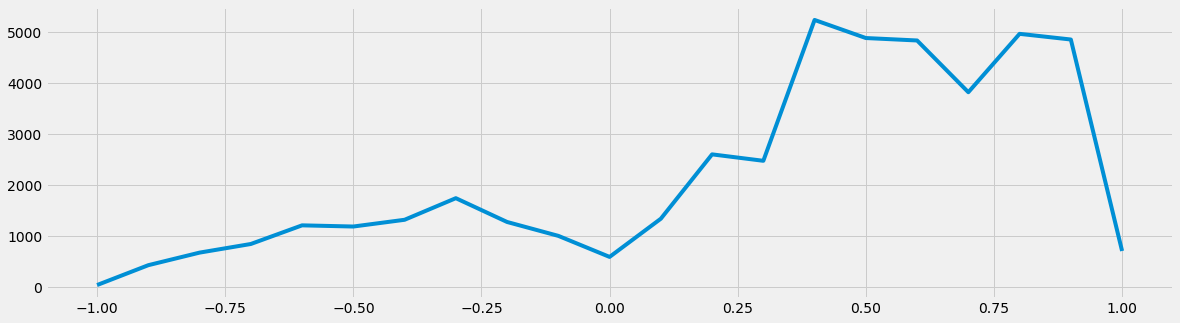

In [111]:
# Plot score distribution
x['roundedCompoundScore'] = x['compoundScore'].round(1)
plt.plot(x.groupby('roundedCompoundScore')['compoundScore'].count())

<ipython-input-105-18d24d51e8a9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['date'] = pd.to_datetime(x['created_at']).dt.date


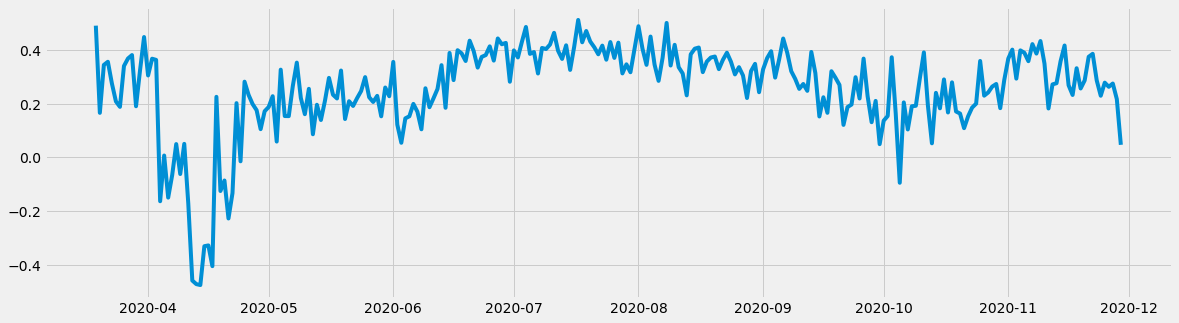

In [105]:
# Plot average score over time for United Kingdom countries

x = df.query("user_location == '" + prominentCountries[1] + "'")

x['date'] = pd.to_datetime(x['created_at']).dt.date
dates = np.array(x['date'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.plot(x.groupby('date').mean()['compoundScore'])

<ipython-input-106-10659adea910>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['date'] = pd.to_datetime(x['created_at']).dt.date


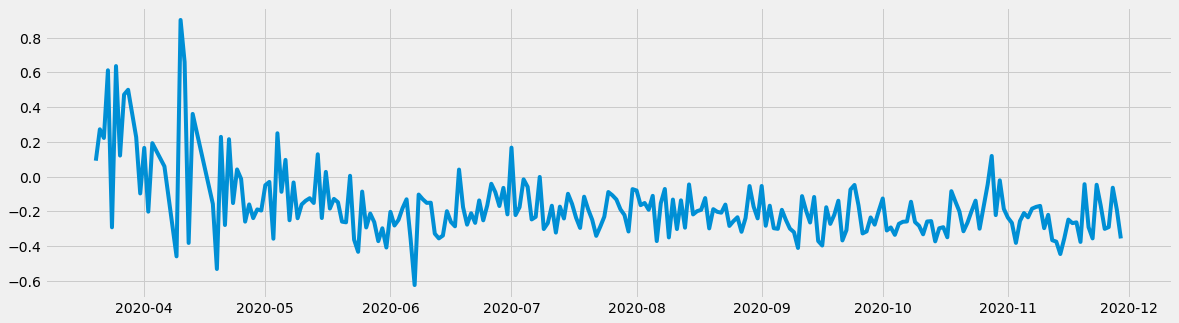

In [106]:
# Plot average score over time for Ireland countries

x = df.query("user_location == '" + prominentCountries[2] + "'")

x['date'] = pd.to_datetime(x['created_at']).dt.date
dates = np.array(x['date'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.plot(x.groupby('date').mean()['compoundScore'])

<ipython-input-108-613b45349e77>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['date'] = pd.to_datetime(x['created_at']).dt.date


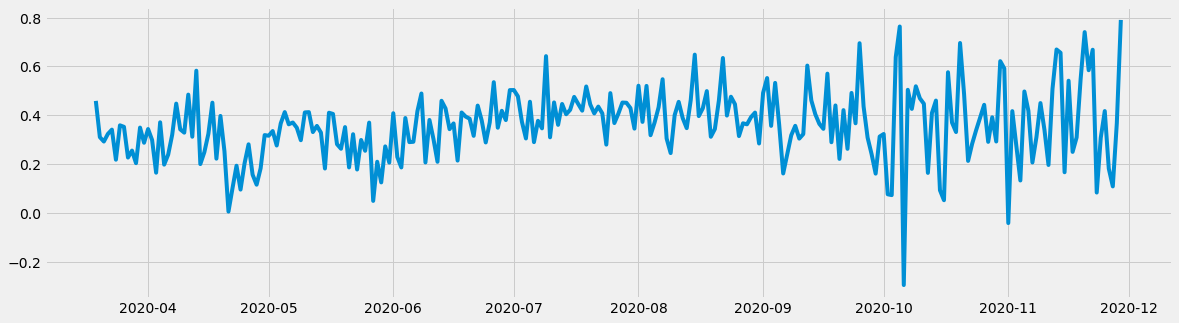

In [108]:
# Plot average score over time for India countries

x = df.query("user_location == '" + prominentCountries[3] + "'")

x['date'] = pd.to_datetime(x['created_at']).dt.date
dates = np.array(x['date'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.plot(x.groupby('date').mean()['compoundScore'])

<ipython-input-109-e720278065f0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['date'] = pd.to_datetime(x['created_at']).dt.date


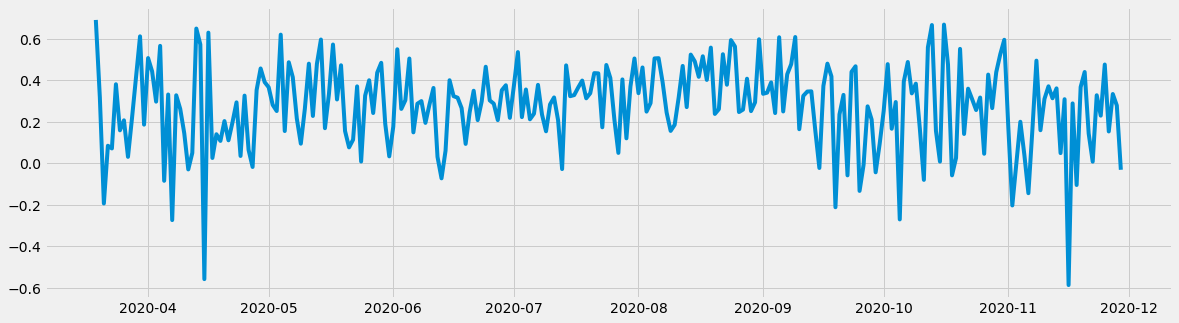

In [109]:
# Plot average score over time for India countries

x = df.query("user_location == '" + prominentCountries[4] + "'")

x['date'] = pd.to_datetime(x['created_at']).dt.date
dates = np.array(x['date'])
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.plot(x.groupby('date').mean()['compoundScore'])